# 0.라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import sympy as sp
from scipy.integrate import odeint
from scipy.optimize import least_squares

from statsmodels.tsa.statespace.sarimax import SARIMAX

# matplotlib에 한글 출력되게 해주는 함수
mpl.rc('font', family = 'Gulim')
mpl.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings(action='ignore')

# 1.인구 데이터 전처리

## 1.1.인구데이터 불러오기

In [2]:
# 원본 인구 데이터 불러오기
pop_org = pd.read_csv('data/population_orgin_통계청.csv', encoding ='cp949')
pop_org.head(1)

,가정별,성별,연령별,항목,단위,1960 년,1961 년,1962 년,1963 년,1964 년,...,2062 년,2063 년,2064 년,2065 년,2066 년,2067 년,2068 년,2069 년,2070 년,Unnamed: 116
0,중위 추계(기본 추계: 출산율-중위 / 기대수명-중위 / 국제순이동-중위),전체,0세,추계인구,NaN,1006018,971960,959898,956092,925433,...,181939,184280,187000,189763,192277,194312,195713,196394,196338,NaN


## 1.2.년도별 연령별 인구 데이터프레임 생성

In [3]:
# 성별이 전체인 데이터만 추출
pop_org = pop_org.loc[pop_org['성별'] == '전체',:]

# 이후 모델링에서 필요하지 않은 컬럼명 제외한 후, index = 년도가 되도록 전치행렬
pop_org = pop_org.drop(['가정별', '성별', '항목', '단위', 'Unnamed: 116'], axis = 1).T

# 각 컬럼명을 연령으로 변경
pop_org.columns = pop_org.loc['연령별',:]

# 데이터의 첫 행은 '연령'이므로 첫 행 제외
pop_org = pop_org.iloc[1:,:]

# object인 인덱스를 int로 변경
pop_org['년도'] = pop_org.index
pop_org = pop_org.replace(regex=r'[ 년]', value='')
pop_org.index = pop_org['년도'].astype(int)
pop_org.columns.name = None
pop_org.index.name = None
pop_org = pop_org.drop('년도', axis = 1)

# 이후 연령별 비율 예측 regression 모델링시의 편의를 위해 '80세 이상' 컬럼 명을 '80세'로 변경
pop_org.rename(columns = {'80세이상' : '80세'}, inplace = True)
pop_org['총인구수'] = pop_org.sum(axis = 1)
pop_org.head()

,0세,1세,2세,3세,4세,5세,6세,7세,8세,9세,...,72세,73세,74세,75세,76세,77세,78세,79세,80세,총인구수
1960,1006018,979267,920017,859056,826454,802342,713175,642165,623335,569516,...,42299,40495,33567,26430,23917,23585,18481,18786,59182,25012374
1961,971960,1003769,977484,918528,857703,825140,801003,711846,640827,621926,...,40650,39553,36584,30840,24838,22202,21231,17374,65394,25765673
1962,959898,970106,1001525,975704,917042,856352,823827,799667,710519,639492,...,44836,38748,37516,33552,28817,23774,20978,19410,68467,26513030
1963,956092,957618,968257,999286,973927,915558,855003,822517,798333,709195,...,47653,42146,36655,35320,30675,26674,22598,19520,72121,27261747
1964,925433,953462,955344,966411,997052,972153,914077,853656,821209,797000,...,48023,43626,39910,34938,33501,28306,24873,21779,75588,27984155


## 1.3.년도별 학령인구수, 학령인구비율, 총인구수 데이터프레임 생성

In [4]:
pop = pd.DataFrame()
pop['년도'] = pop_org.index

# 년도별 총인구수
pop['총인구수'] = list(pop_org['총인구수'])

# 년도별 학령인구수(6세 ~ 21세)
pop['학령인구수'] = 0
for i in pop.index:
    for age in range(6, 22):
        pop.loc[i, '학령인구수'] = pop.loc[i, '학령인구수'] + pop_org.loc[i+1960, f'{age}세']

# 년도별 학령인구비율
pop['학령인구비율'] = 100 * pop['학령인구수'] / pop['총인구수']
pop.loc[20:25,:]

,년도,총인구수,학령인구수,학령인구비율
20,1980,38123775,14400990,37.774302
21,1981,38723248,14293112,36.910933
22,1982,39326352,14127253,35.923121
23,1983,39910403,13972832,35.010501
24,1984,40405956,13846611,34.268738
25,1985,40805744,13746736,33.688238


## 1.4.모델별로 예측한 수치들을 비교할 데이터프레임 생성

In [5]:
pred = pd.DataFrame()
pred['년도'] = [i for i in range(2021, 2061)]

# 2.총인구수 예측 수리 모델링

## 2.1.피팅할 데이터프레임 생성

In [6]:
# 1980년 ~ 2020년의 년도, 총인구수
fit_total = pop[['년도', '총인구수']]
fit_total = fit_total.loc[fit_total['년도']<=2020, :]
print(fit_total.head(1))
print(fit_total.tail(1))

     년도      총인구수
0  1960  25012374
      년도      총인구수
60  2020  51836239


## 2.2.총인구수 모델

최적의 r: 0.050203168979557594, 최적의 K: 54488908.29241143


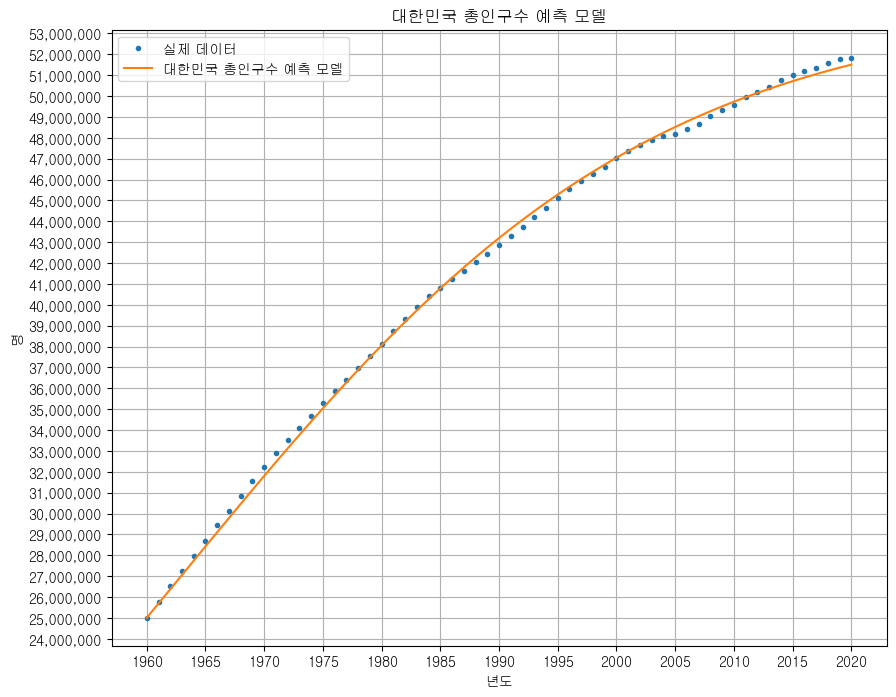

In [7]:
# 로지스틱 함수를 미분방정식 형태로 정의(베르누이)
def model_total(P, t, r, K):
    dPdt = r * P * (1 - P / K)
    return dPdt

# 목적 함수 정의
def objective_total(params, t, P_obs):
    r, K = params
    P_model = odeint(model_total, P0, t, args=(r, K))
    return P_model.flatten() - P_obs

# 초기 조건
P0 = fit_total['총인구수'].iloc[0]  # 초기 총인구

# 시간 범위
t = np.array(fit_total['년도'] - fit_total['년도'].iloc[0])

# 관측 데이터
P_obs = fit_total['총인구수'].values

# 초기 추정값
initial_guess = [0.1, 1e8]  # 성장률과 캐리 팩터에 대한 초기 추정값

# 최적화 수행
result = least_squares(objective_total, initial_guess, args=(t, P_obs))

# 결과 출력
r_opt, K_opt = result.x
print(f"최적의 r: {r_opt}, 최적의 K: {K_opt}")

# 최적의 매개 변수를 사용하여 모델 피팅
P_fit = odeint(model_total, P0, t, args=(r_opt, K_opt))

# 결과를 시각화
plt.figure(figsize=(10,8))
plt.plot(fit_total['년도'], P_obs, '.', label='실제 데이터')
plt.plot(fit_total['년도'], P_fit, label='대한민국 총인구수 예측 모델')
plt.title('대한민국 총인구수 예측 모델')
plt.xlabel('년도')
plt.ylabel('명')
plt.legend()
plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(base=1e6))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(base=5))
plt.grid(True)
plt.show()

In [8]:
# P를 나타내는 변수
t, P = sp.symbols('t P')

# 로지스틱 성장 모델의 방정식
logistic_equation = K_opt / (1 + sp.exp(-r_opt * (t))) 

# 로지스틱 성장 모델의 미분 방정식
dP_dt_equation = sp.diff(logistic_equation, t)

# 결과 출력
print("로지스틱 성장 모델의 방정식 P(t):")
print(logistic_equation)

print("\n로지스틱 성장 모델의 미분 방정식 dP/dt:")
print(dP_dt_equation)

로지스틱 성장 모델의 방정식 P(t):
54488908.2924114/(1 + exp(-0.0502031689795576*t))

로지스틱 성장 모델의 미분 방정식 dP/dt:
2735515.87051555*exp(-0.0502031689795576*t)/(1 + exp(-0.0502031689795576*t))**2


## 2.3.2021년 ~ 2060년까지의 총인구수 예측

In [9]:
# 총인구수 예측 함수
def predict_total(year):
    future_time = year
    t_value = future_time - 1960
    P_t = K_opt / (1 + np.exp(-r_opt * t_value))
    return(P_t)

In [10]:
# 예측된 총인구수를 저장할 리스트
pred_total = []

# 2021년부터 2060년까지 총인구수 예측
for i in range(2021,2061):
    pred_total.append(int(predict_total(i)))
pred['총인구수'] = pred_total
pred.head(2)

,년도,총인구수
0,2021,52054048
1,2022,52168190


# 3.경제지표 데이터 전처리

## 3.1.경제지표 데이터 불러오기

In [11]:
# 원본 경제지표 데이터 불러오기
weo_orgin = pd.read_csv('data/WEO_Data.csv')
weo_orgin.head(2)

,Country,Subject Descriptor,Units,Scale,Country/Series-specific Notes,1980,1981,1982,1983,1984,...,2018,2019,2020,2021,2022,2023,2024,2025,2026,Estimates Start After
0,Korea,"Gross domestic product, constant prices",National currency,Billions,Source: Central Bank Latest actual data: 2020 ...,"174,901.90","187,575.50","203,215.80","230,398.30","254,709.10",...,"1,812,005.30","1,848,958.40","1,831,249.60","1,896,900.82","1,950,073.84","1,999,823.11","2,047,243.76","2,094,057.94","2,141,942.00",2020.0
1,Korea,"Gross domestic product, constant prices",Percent change,NaN,"See notes for: Gross domestic product, consta...",-1.646,7.246,8.338,13.376,10.552,...,2.907,2.039,-0.958,3.585,2.803,2.551,2.371,2.287,2.287,2020.0


## 3.2.경제지표 데이터 전처리

In [12]:
# column명을 'Subject Descriptor' + '_' + 'Units'으로 변경
weo_orgin.index = weo_orgin['Subject Descriptor'] + '_' + weo_orgin['Units']

# 사용하지 않을 데이터 제거
weo_orgin = weo_orgin.iloc[:-2,5:]

# 전치행렬로 변경
weo_orgin = weo_orgin.T

# object로 저장되어 있는 수치 데이터 형식을 float로 변경
weo_orgin = weo_orgin.replace(regex=r'[,]', value='')
for c in weo_orgin.columns:
    weo_orgin[c] = weo_orgin[c].astype('float')

# 각 feature가 언제까지 진짜 데이터인지 적혀있는 데이터 추출
weo_estimate_after = weo_orgin.iloc[-1, :].astype(int)

# 마지막 행 제외(Estimate After 정보)
weo_orgin = weo_orgin.iloc[:-1, :]

# 기존에 object인 index 데이터 타입을 int로 변경
weo_orgin['year']= weo_orgin.index
weo_orgin['year'] = weo_orgin['year'].astype(int)
weo_orgin.index = weo_orgin['year']
weo_orgin.index.name = None
weo_orgin = weo_orgin.drop('year', axis = 1)

weo_orgin.head(2)


,"Gross domestic product, constant prices_National currency","Gross domestic product, constant prices_Percent change","Gross domestic product, current prices_National currency","Gross domestic product, current prices_U.S. dollars","Gross domestic product, current prices_Purchasing power parity; international dollars","Gross domestic product, deflator_Index","Gross domestic product per capita, constant prices_National currency","Gross domestic product per capita, constant prices_Purchasing power parity; 2017 international dollar","Gross domestic product per capita, current prices_National currency","Gross domestic product per capita, current prices_U.S. dollars",...,General government structural balance_Percent of potential GDP,General government primary net lending/borrowing_National currency,General government primary net lending/borrowing_Percent of GDP,General government net debt_National currency,General government net debt_Percent of GDP,General government gross debt_National currency,General government gross debt_Percent of GDP,"Gross domestic product corresponding to fiscal year, current prices_National currency",Current account balance_U.S. dollars,Current account balance_Percent of GDP
1980,174901.9,-1.646,39725.1,65.368,82.796,22.713,4587738.23,5486.84,1042003.32,1714.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39725.1,-6.896,-10.550
1981,187575.5,7.246,49669.8,72.934,97.197,26.480,4844002.24,5793.32,1282686.82,1883.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49669.8,-6.487,-8.895


## 3.3. 각 feature 별 Pearson 상관계수 계산

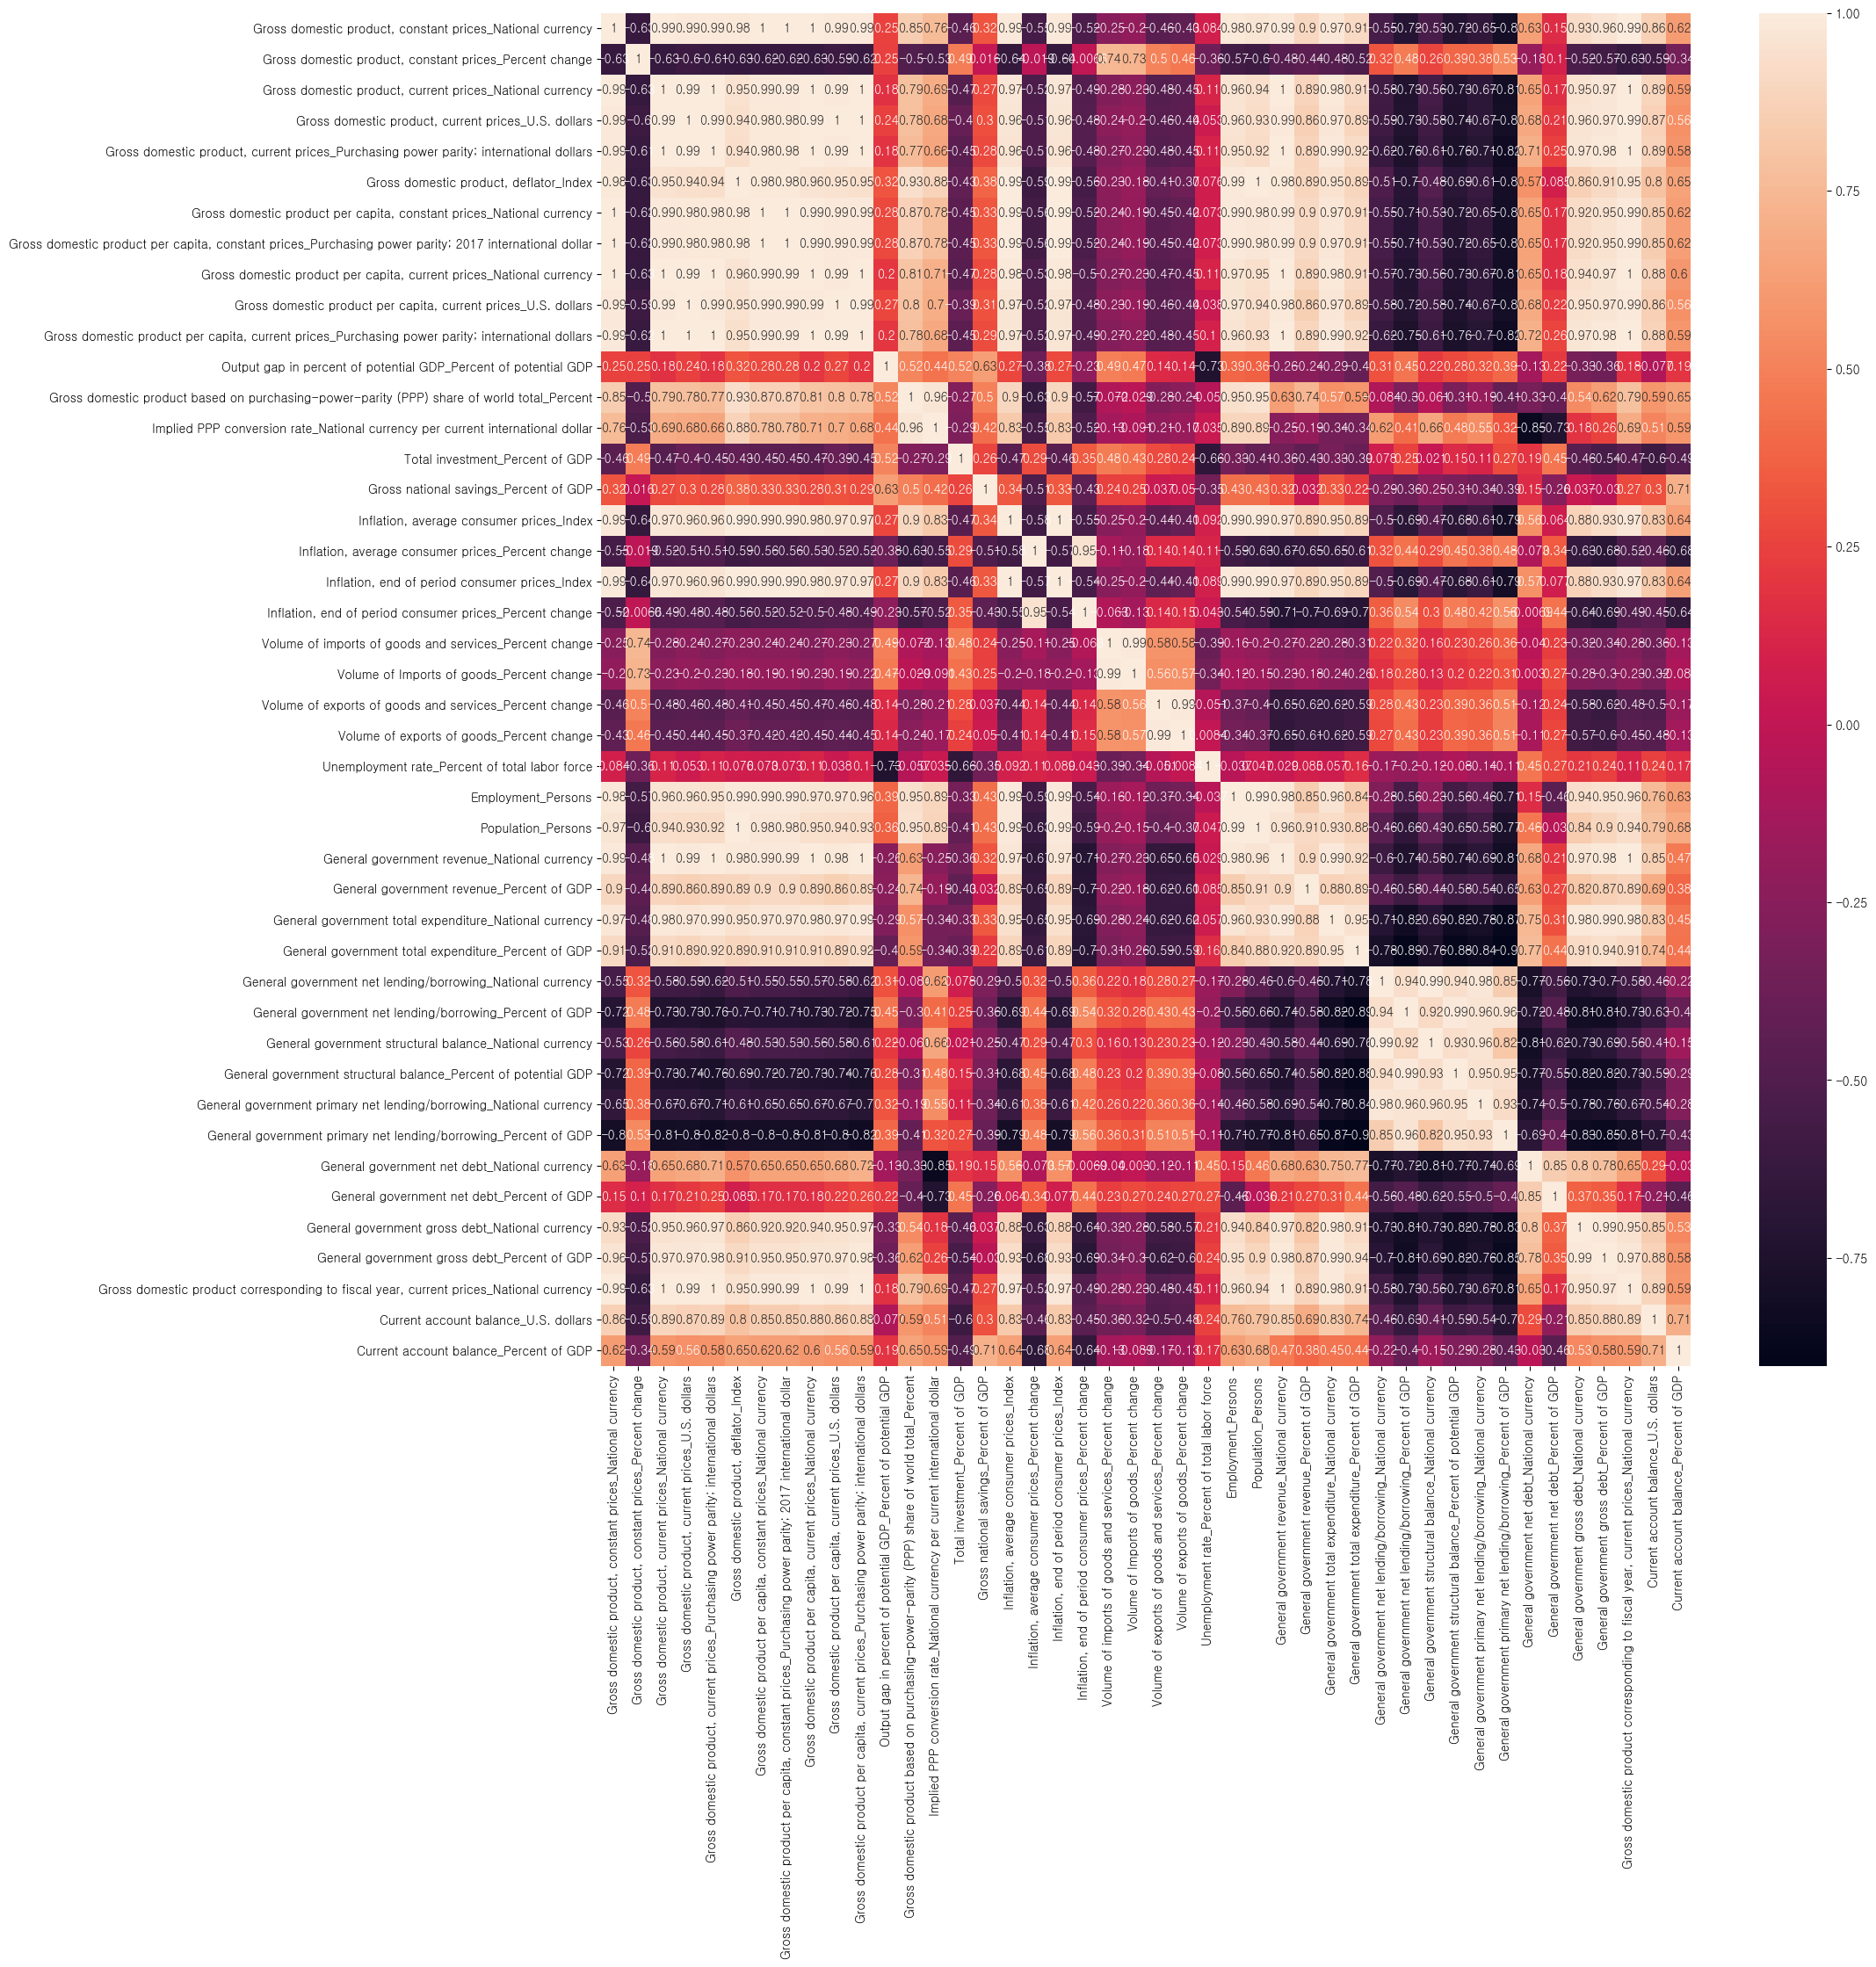

In [13]:
# Pearson 상관계수
corr = weo_orgin.corr()

# Heat Map : 상관계수 시각화
plt.figure(figsize = (20,20))
sns.heatmap(corr, annot = True)
plt.show()

## 3.4.결측치 확인

In [14]:
# 결측치 확인
weo_orgin.isnull().sum()

Gross domestic product, constant prices_National currency                                                 0
Gross domestic product, constant prices_Percent change                                                    0
Gross domestic product, current prices_National currency                                                  0
Gross domestic product, current prices_U.S. dollars                                                       0
Gross domestic product, current prices_Purchasing power parity; international dollars                     0
Gross domestic product, deflator_Index                                                                    0
Gross domestic product per capita, constant prices_National currency                                      0
Gross domestic product per capita, constant prices_Purchasing power parity; 2017 international dollar     0
Gross domestic product per capita, current prices_National currency                                       0
Gross domestic product per c

## 3.5.feature selection

서로 상관관계가 큰 feature가 많으므로 아래 기준을 통해서 2개의 feature 선택

- feature selection 기준
1. 결측치가 없는 변수
2. 서로 상관관계가 0.90 이상으로 묶인 그룹 중 가장 큰 그룹 2개 선택
3. 각 그룹에 속하는 변수 중 다른 컬럼과의 상관계수가 소수점 셋째자리에서 반올림한 수치가 1인 것이 가장 많은 변수 1개 선택


In [15]:
# 선택된 2개 feature
selected_feature = ['Gross domestic product, current prices_Purchasing power parity; international dollars',
                    'Gross domestic product per capita, current prices_National currency']

# 선택된 feature의 이름이 너무 김 => feature 이름 축약
shorten_feature = {'GDP_global' : 'Gross domestic product, current prices_Purchasing power parity; international dollars',
                   'GDP_national' : 'Gross domestic product per capita, current prices_National currency'}

In [16]:
# 선택된 feature 있는 데이터 프레임 생성
weo = weo_orgin[selected_feature]

# 데이터프레임 feature 명 축약
weo.columns = shorten_feature.keys()
weo.head()

,GDP_global,GDP_national
1980,82.796,1042003.32
1981,97.197,1282686.82
1982,111.807,1456697.54
1983,131.728,1705823.42
1984,150.882,1945042.46


# 4.경제지표 데이터 예측 수리 모델링

## 4.1.GDP_global 예측

In [17]:
# 예측한 경제지표 데이터를 저장할 데이터프레임 생성
GDP_pred = pd.DataFrame()
GDP_pred.index = [i for i in range(2021, 2061)]

### 4.1.1.피팅할 GDP_global 데이터 추출

In [18]:
# 피팅할 GDP_global 데이터 프레임 생성
GDP_global = pd.DataFrame()

# weo 데이터 프레임에서 GDP_global 값 선택
GDP_global['Year'] = weo.index
GDP_global['GDP_global'] = list(weo['GDP_global'])

# GDP_global의 실제값들까지만 fitting에 사용
GDP_global = GDP_global.loc[GDP_global['Year'] < weo_estimate_after[shorten_feature['GDP_global']],:]
GDP_global.tail(2)

,Year,GDP_global
38,2018,2219.15
39,2019,2304.83


### 4.1.2. GDP_global 모델

a: 1.1026484419143026, b: 14.639300327907074, c: 71.27731809874894


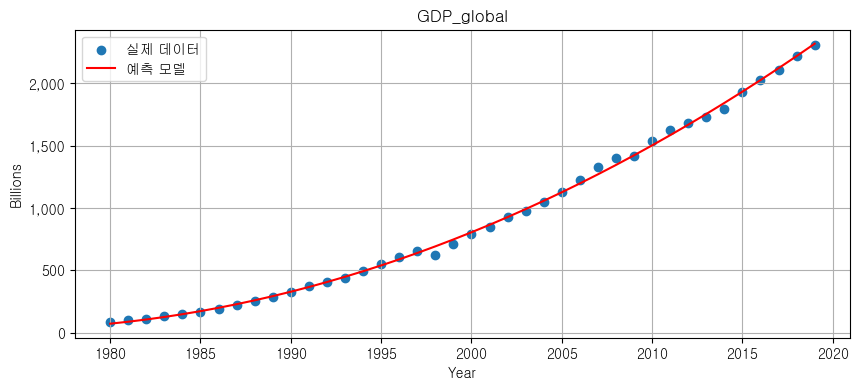

In [19]:
# GDP_glbal 모델 함수 정의 (이차다항함수)
def GDP_global_model(params, t, data):
    a, b, c = params
    return a * (t - 1980)**2 + b * (t - 1980) + c - data

# 'Year' 열을 정수로 변환
GDP_global['Year'] = GDP_global['Year']

# 초기 추정값
initial_guess = [1.0, 0.01, 1.0]

# NLQS를 사용하여 모델 파라미터 추정
result = least_squares(GDP_global_model, initial_guess, args=(GDP_global['Year'], GDP_global['GDP_global']))

# 추정된 파라미터 출력
a, b, c = result.x
print(f"a: {a}, b: {b}, c: {c}")

# 모델을 사용하여 예측값 계산
predicted_gdp = GDP_global_model([a, b, c], GDP_global['Year'], 0)

# 시각화
plt.figure(figsize=(10,4))
plt.scatter(GDP_global['Year'], GDP_global['GDP_global'], label='실제 데이터')
plt.plot(GDP_global['Year'], predicted_gdp, label='예측 모델', color='red')
plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('GDP_global')
plt.xlabel('Year')
plt.ylabel('Billions')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# 파라미터들을 심볼에 할당
t, a, b, c = sp.symbols('t a b c')

# 이차다항식 수식 정의
model_equation = a * (t - 1980)**2 + b * (t - 1980) + c

# 피팅된 파라미터들 사용
predicted_equation = model_equation.subs({a: result.x[0], b: result.x[1], c: result.x[2]})

# 방정식 출력
print("Predicted Equation:", sp.simplify(predicted_equation))

Predicted Equation: 1.1026484419143*t**2 - 4351.84852965273*t + 4293908.41434967


### 4.1.3.2021년 ~ 2060년까지 GDP_global 데이터 예측

In [21]:
# 예측된 GDP_global 값 저장할 리스트 선언
pred_gobal = []

# 2021년부터 2060년까지의 GDP_global값 예측
for i in range(2021,2061):
    pred_gobal.append(GDP_global_model([result.x[0],result.x[1],result.x[2]],i,0))

# 예측한 GDP_global값 데이터프레임에 저장
GDP_pred["GDP_global"] = pred_gobal
GDP_pred.head()

,GDP_global
2021,2525.040662
2022,2631.199783
2023,2739.564201
2024,2850.133916
2025,2962.908928


## 4.2.GDP_national 예측

### 4.2.1.피팅할 GDP_national 데이터 추출

In [22]:
# 피팅할 GDP_national 데이터 프레임 생성
GDP_national = pd.DataFrame()

# weo 데이터 프레임에서 GDP_national 값 선택
GDP_national['Year'] = weo.index
GDP_national['GDP_national'] = list(weo['GDP_national'])

# GDP_national 실제값들까지만 fitting에 사용
GDP_national = GDP_national.loc[GDP_national['Year'] < weo_estimate_after[shorten_feature['GDP_national']],:]
GDP_national.tail(2)

,Year,GDP_national
37,2017,35740455.61
38,2018,36781950.10


### 4.2.2. GDP_national 모델

a: 16098.109132432264, b: 371054.30656173755, c: 136392.81578424422


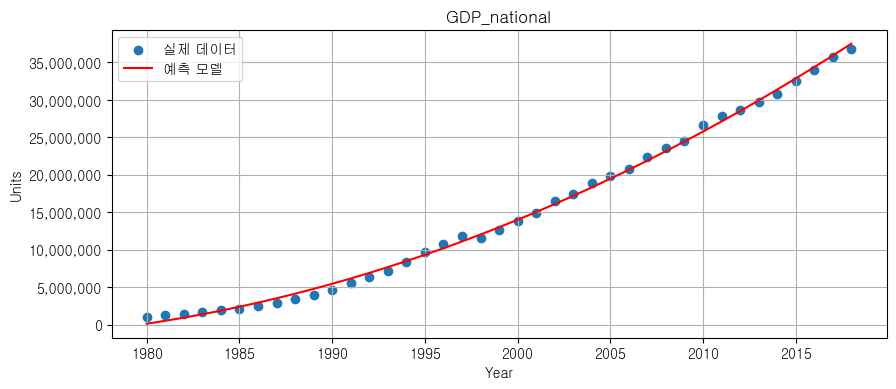

In [23]:
# 모델 함수 정의 (이차다항함수)
def GDP_national_model(params, t, data):
    a, b, c = params
    return a * (t - 1980)**2 + b * (t - 1980) + c - data

# 'Year' 열을 정수로 변환
GDP_national['Year'] = GDP_national['Year'].astype(int)

# 초기 추정값
initial_guess = [1.0, 0.01, 1.0]

# NLQS를 사용하여 모델 파라미터 추정
result = least_squares(GDP_national_model, initial_guess, args=(GDP_national['Year'], GDP_national['GDP_national']))

# 추정된 파라미터 출력
a, b, c = result.x
print(f"a: {a}, b: {b}, c: {c}")

# 모델을 사용하여 예측값 계산
predicted_gdp = GDP_national_model([a, b, c], GDP_national['Year'], 0)

# 시각화
plt.figure(figsize=(10,4))
plt.scatter(GDP_national['Year'], GDP_national['GDP_national'], label='실제 데이터')
plt.plot(GDP_national['Year'], predicted_gdp, label='예측 모델', color='red')
plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('GDP_national')
plt.xlabel('Year')
plt.ylabel('Units')

plt.legend()
plt.grid(True)
plt.show()

In [24]:
# 파라미터들을 심볼에 할당
t, a, b, c = sp.symbols('t a b c')

# 이차다항식 수식 정의
model_equation = a * (t - 1980)**2 + b * (t - 1980) + c

# 피팅된 파라미터들 사용
predicted_equation = model_equation.subs({a: result.x[0], b: result.x[1], c: result.x[2]})

# 방정식 출력
print("Predicted Equation:", sp.simplify(predicted_equation))

Predicted Equation: 16098.1091324323*t**2 - 63377457.85787*t + 62376475908.611


### 4.2.3. 2021년 ~ 2060년까지 GDP_national 데이터 예측

In [25]:
# 예측된 GDP_national 값 저장할 리스트 선언
pred_national = []

# 2021년부터 2060년까지의 GDP_national 예측
for i in range(2021,2061):
    pred_national.append(GDP_national_model([result.x[0], result.x[1], result.x[2]], i, 0))

# 예측한 GDP_national 데이터프레임에 저장
GDP_pred['GDP_national'] = pred_national
GDP_pred.tail(2)

,GDP_global,GDP_national
2059,8109.410970,1.299180e+08
2060,8299.371373,1.328486e+08


# 5.학령인구수 수리 모델링 without 경제지표 데이터

In [26]:
# 1980년부터 2020년까지의 년도와 학령인구수만을 피팅 데이터로 사용
train = pop.loc[(1980 <= pop['년도']) & (pop['년도'] <=2020), ['년도', '학령인구수']]
train

,년도,학령인구수
20,1980,14400990
21,1981,14293112
22,1982,14127253
23,1983,13972832
24,1984,13846611
25,1985,13746736
26,1986,13674112
27,1987,13662464
28,1988,13645895
29,1989,13582384


## 5.1.Exponential 함수 사용 ( 기각 )

a: 14887323.018348616, b: -0.014166726624732756


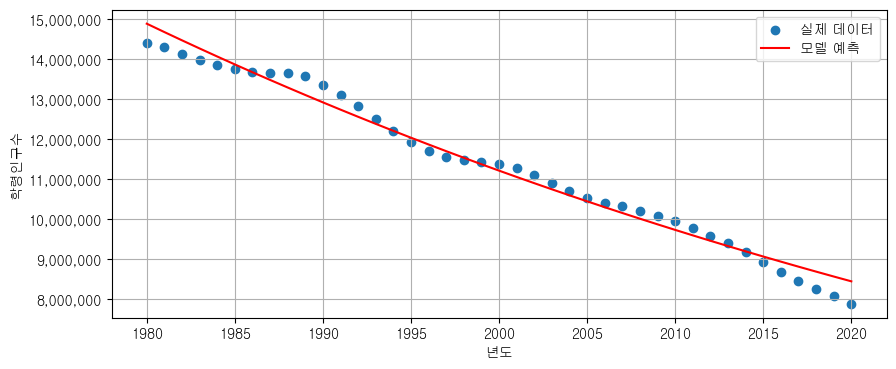

In [27]:
# 모델 함수 정의(지수함수)
def pop_exp_model(params, t, data):
    a, b = params
    return a * np.exp(b * (t - 1980)) - data

# 'Year' 열을 정수로 변환
train['년도'] = train['년도'].astype(int)

# 초기 추정값
initial_guess = [1.0, 0.01]

# NLQS를 사용하여 모델 파라미터 추정
result = least_squares(pop_exp_model, initial_guess, args=(train['년도'], train['학령인구수']))

# 추정된 파라미터 출력
a, b = result.x
print(f"a: {a}, b: {b}")

# 모델을 사용하여 예측값 계산
pred_exp_pop_range = pop_exp_model([a, b], train['년도'], 0)

# 시각화
plt.figure(figsize=(10,4))
plt.scatter(train['년도'], train['학령인구수'], label='실제 데이터')
plt.plot(train['년도'], pred_exp_pop_range, label='모델 예측', color='red')
plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('년도')
plt.ylabel('학령인구수')
plt.grid(True)
plt.legend()
plt.show()


In [28]:
# 예측된 학령인구수를 저장할 리스트 선언
pred_exp = []

# exponential 함수를 이용하여 2021년 부터 2060년까지의 학령인구수 예측
for year in range(2021, 2061):
    pred_exp.append(pop_exp_model([a, b], year, 0))

# 예측된 학령인구수 데이터프레임에 저장
pred['exponential'] = pred_exp

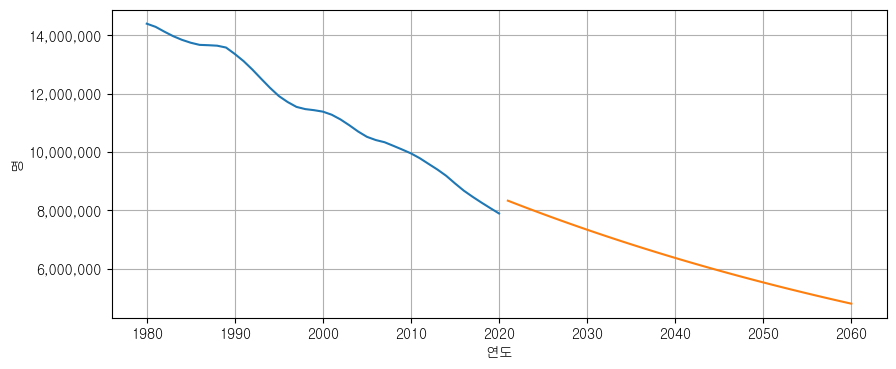

In [29]:
# 예측값 시각화
plt.figure(figsize=(10,4))
plt.plot(train["년도"], train["학령인구수"])
plt.plot(pred["년도"], pred["exponential"])
plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel("연도")
plt.ylabel("명")
plt.grid(True)
plt.show()

## 5.2.이차다항함수 ( 기각 )

a: -417.6018474549828, b: -145964.51564730058, c: 14514710.767991394


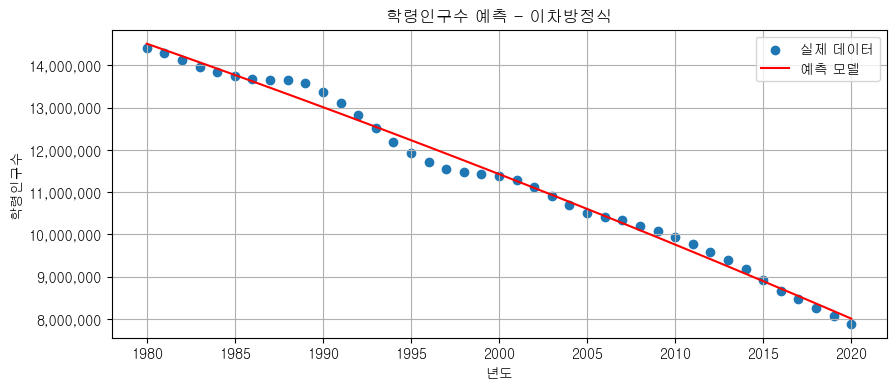

In [30]:
# 모델 함수 정의 (이차다항함수)
def poly_model(params, t, data):
    a, b, c = params
    return a * (t - 1980)**2 + b * (t - 1980) + c - data

# 'Year' 열을 정수로 변환
train['년도'] = train['년도'].astype(int)

# 초기 추정값
initial_guess = [1.0, 0.01, 1.0]

# NLQS를 사용하여 모델 파라미터 추정
result = least_squares(poly_model, initial_guess, args=(train['년도'], train['학령인구수']))

# 추정된 파라미터 출력
a, b, c = result.x
print(f"a: {a}, b: {b}, c: {c}")

# 모델을 사용하여 예측값 계산
pred_poly_pop_range = poly_model([a, b, c], train['년도'], 0)

# 시각화
plt.figure(figsize=(10,4))
plt.scatter(train['년도'], train['학령인구수'], label='실제 데이터')
plt.plot(train['년도'], pred_poly_pop_range, label='예측 모델', color='red')
plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('학령인구수 예측 - 이차방정식')
plt.xlabel('년도')
plt.ylabel('학령인구수')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# 예측한 학령인구수를 저장할 리스트 선언
pred_poly = []

# 이차다항함수를 이용하여 2021년부터 2060년까지의 학령인구수 예측
for year in range(2021, 2061):
    pred_poly.append(poly_model([a,b,c], year, 0))

# 예측된 학령인구수 데이터프레임에 저장
pred['poly'] = pred_poly

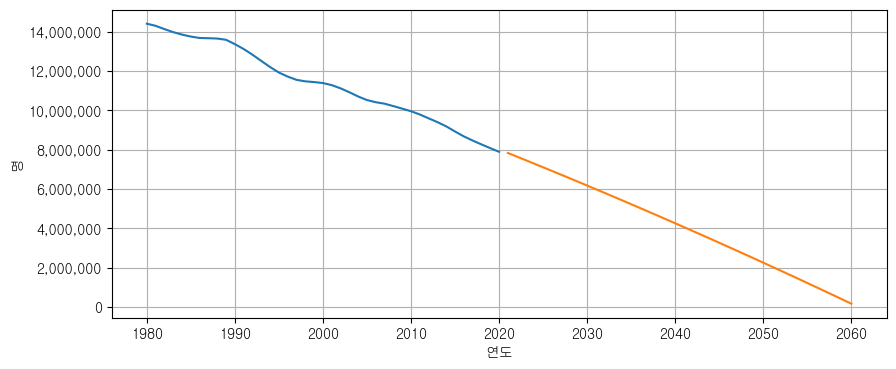

In [32]:
# 예측값 시각화
plt.figure(figsize=(10,4))
plt.plot(train["년도"], train["학령인구수"])
plt.plot(pred["년도"], pred["poly"])
plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel("연도")
plt.ylabel("명")
plt.grid(True)
plt.show()

# 6.학령인구수 수리모델링 with 경제지표 ( 기각 )

In [33]:
# 1980년부터 2020년까지 년도, 총인구수, GDP_global, GDP_national, 학령인구수를 훈련데이터로 사용
train = pd.DataFrame()
train['년도'] = [i for i in range(1980, 2021)]
train['총인구수'] = list(pop.loc[(1980 <= pop['년도']) & (pop['년도'] <= 2020), '총인구수'])
train['GDP_global'] = list(weo.loc[1980:2020, 'GDP_global'])
train['GDP_national'] = list(weo.loc[1980:2020, 'GDP_national'])
train['학령인구수'] = list(pop.loc[(1980 <= pop['년도']) & (pop['년도'] <= 2020), '학령인구수'])

Optimized Parameters: [ 9.56592274e+00  5.92910228e-08 -1.54072578e-03  8.45234410e+03
 -7.06889057e-01  1.40091442e+07]


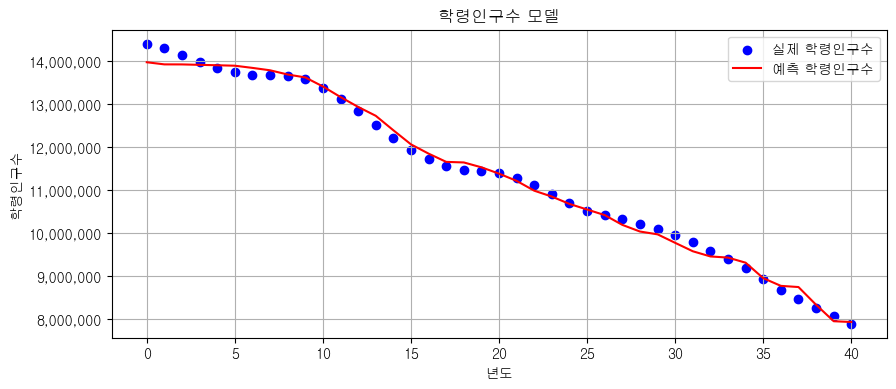

Final Model Formula: y = 9.57 * x1^2 + 0.00 * x2^2 + -0.00 * x1 * x2 + 8452.34 * x1 + -0.71 * x2 + 14009144.16


In [34]:
# 가우시안 잡음(Gaussian noise) 생성
np.random.seed(42)
train["Gaussian noise"] = 0.1 * np.random.randn(41)
train["학령인구수"] = train["학령인구수"] + train["Gaussian noise"]

# 이차다변수다항함수 모델 정의
def model(params, x1, x2):
    a, b, c, d, e, f = params
    return a * x1**2 + b * x2**2 + c * x1 * x2 + d * x1 + e * x2 + f

# 초기 추정값 설정
initial_params = np.ones(6)

# 최소 제곱법으로 파라미터 추정
result = least_squares(
    fun=lambda params: model(params, train['GDP_global'], train['GDP_national']) - train['학령인구수'],
    x0=initial_params
)

# 파라미터 출력
optimized_params = result.x
print("Optimized Parameters:", optimized_params)

# 데이터 fitting 결과 시각화
y_pred = model(optimized_params, train['GDP_global'], train['GDP_national'])

# 시각화
plt.figure(figsize=(10, 4))
plt.scatter(range(41), train['학령인구수'], label='실제 학령인구수', color='blue')
plt.plot(range(41), y_pred, label='예측 학령인구수', color='red')
plt.title('학령인구수 모델')
plt.xlabel('년도')
plt.ylabel('학령인구수')
plt.legend()
plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.grid(True)
plt.show()

# 이차다변수다항함수 모델 수식 출력
final_model_formula = f"{optimized_params[0]:.2f} * x1^2 + {optimized_params[1]:.2f} * x2^2 + {optimized_params[2]:.2f} * x1 * x2 + {optimized_params[3]:.2f} * x1 + {optimized_params[4]:.2f} * x2 + {optimized_params[5]:.2f}"
print("Final Model Formula: y =", final_model_formula)

In [35]:
# 예측시 사용될 독립변수 추출
future = pd.DataFrame()
future['년도'] = [i for i in range(2021, 2061)]
future['총인구수'] = list(pred['총인구수'])
future['GDP_global'] = list(GDP_pred['GDP_global'])
future['GDP_national'] = list(GDP_pred['GDP_national'])

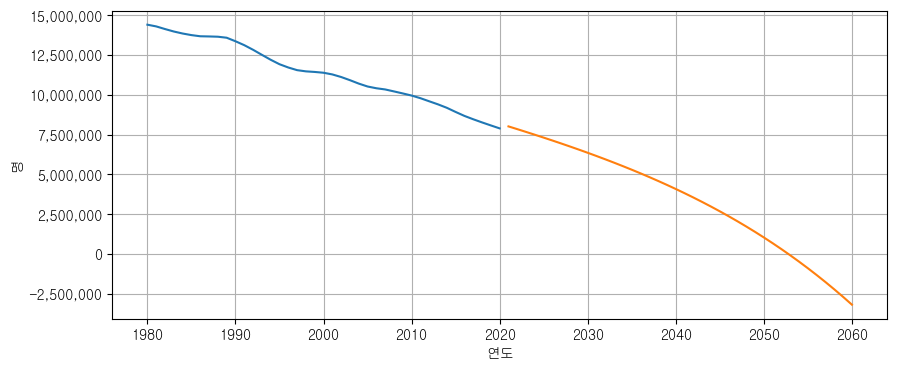

In [36]:
# 모델에 feature들 적용
y_pred = model(optimized_params, future['GDP_global'], future['GDP_national'])
pred["poly_with_weo"] = y_pred

# 시각화
plt.figure(figsize=(10,4))
plt.plot(train["년도"], train["학령인구수"])
plt.plot(pred["년도"], pred["poly_with_weo"])
plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel("연도")
plt.ylabel("명")
plt.grid(True)
plt.show()

# 7.SARIMAX ( 채택 )

In [37]:
# 1980년부터 2020년까지의 총인구수를 독립변수로, 학령인구비율을 종속변수로 사용
train['학령인구비율'] = list(pop.loc[(1980 <= pop['년도']) & (pop['년도']<=2020), '학령인구비율'])

In [38]:
endog = train['학령인구비율'] # 종속변수(y 값)
x_exog = train['총인구수']   # 독립변수(x 값)

# (p,d,q) = (2,1,0), (P,D,Q,s) = (2,1,0,4)
sarimax_model = SARIMAX(endog, exog=x_exog, order=(2,1,0), seasonal_order=(2,1,0,4))
sarimax_model_fit = sarimax_model.fit()
print(sarimax_model_fit.summary())

# 이후 40년(2021년 ~ 2060년)의 학령인구비율 예측
forecast_arimax = sarimax_model_fit.forecast(steps=40, exog = future['총인구수'])
pred['SARIMAX'] = list(forecast_arimax)

# 학령인구비율이므로 학령인구수 = 학령인구비율 * 총인구수 / 100 계산
pred['SARIMAX'] = pred['SARIMAX'] * pred['총인구수'] / 100

                                     SARIMAX Results                                     
Dep. Variable:                            학령인구비율   No. Observations:                   41
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 4)   Log Likelihood                  29.556
Date:                           Thu, 30 Nov 2023   AIC                            -47.111
Time:                                   15:05:43   BIC                            -37.610
Sample:                                        0   HQIC                           -43.795
                                            - 41                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
총인구수       -1.141e-06    3.3e-07     -3.454      0.001   -1.79e-06   -4.94e-07
ar.L1          1.3756      0.287      4.790

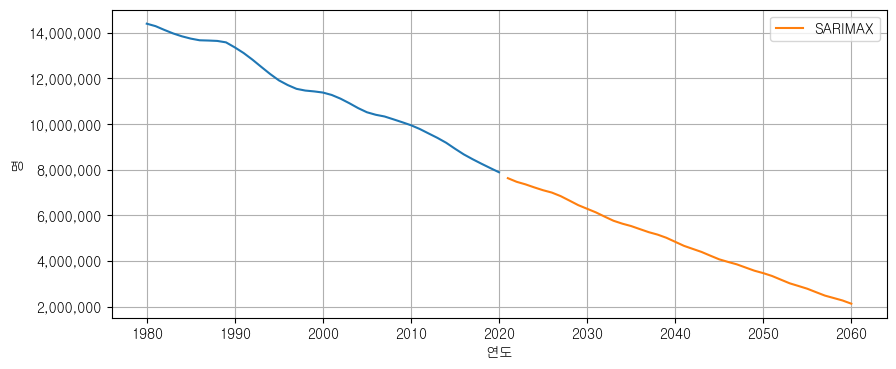

In [39]:
# 시각화
plt.figure(figsize = (10,4))
plt.plot(train["년도"], train["학령인구수"])
plt.plot(pred['년도'], pred['SARIMAX'], label = 'SARIMAX')
plt.grid(True)
plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel("연도")
plt.ylabel("명")
plt.legend(loc='upper right')
plt.show()

# 8.결과비교

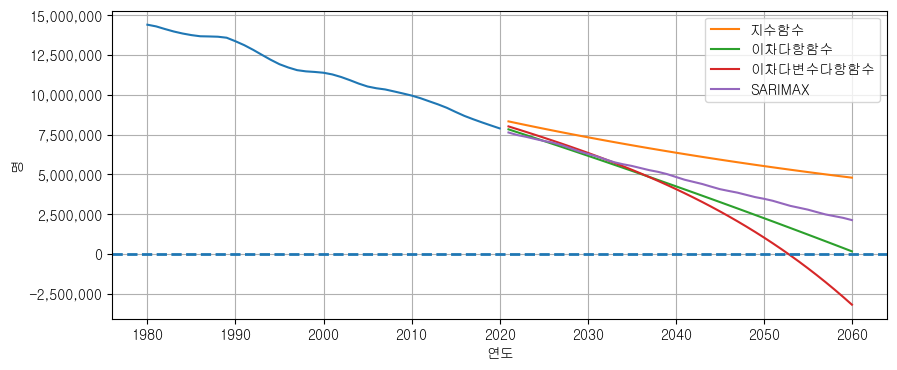

In [40]:
# 시각화
plt.figure(figsize=(10,4))
plt.plot(train["년도"], train["학령인구수"])
plt.plot(pred['년도'], pred['exponential'], label = '지수함수')
plt.plot(pred['년도'], pred['poly'], label = '이차다항함수')
plt.plot(pred['년도'], pred['poly_with_weo'], label = '이차다변수다항함수')
plt.plot(pred["년도"], pred["SARIMAX"], label = 'SARIMAX')
plt.grid(True)
plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel("연도")
plt.ylabel("명")
plt.legend(loc='upper right')
ax = plt.gca()
highlight_y = 0.0000
plt.axhline(y=highlight_y, linestyle='--',linewidth=2)
plt.legend(loc='upper right')
plt.show()

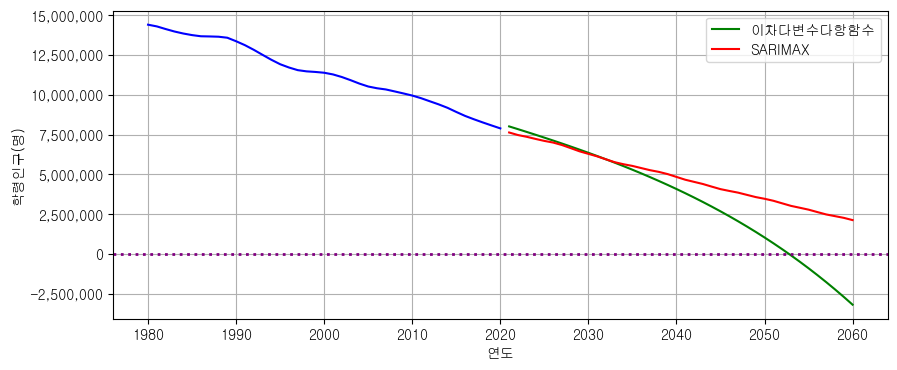

In [41]:
# 시각화
plt.figure(figsize=(10,4))
plt.plot(train["년도"], train["학령인구수"],'b')
plt.plot(pred['년도'],pred['poly_with_weo'], 'g',label = '이차다변수다항함수')
plt.plot(pred["년도"], pred["SARIMAX"],'r', label = 'SARIMAX')
plt.grid(True)
plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel("연도")
plt.ylabel("학령인구(명)")
plt.legend(loc='upper right')
ax = plt.gca()
highlight_y = 0.0000
plt.axhline(y=highlight_y, linestyle=':',linewidth=2, color='purple')
plt.show()

In [42]:
print("2030년 학령인구 예측 : ",pred.iloc[9,-1])
print("2040년 학령인구 예측 : ",pred.iloc[19,-1])
print("2050년 학령인구 예측 : ",pred.iloc[29,-1])
print("2060년 학령인구 예측 : ",pred.iloc[39,-1])

2030년 학령인구 예측 :  6288659.624881279
2040년 학령인구 예측 :  4840741.9111918025
2050년 학령인구 예측 :  3468186.897279333
2060년 학령인구 예측 :  2128656.0906078233


In [43]:
pred

,년도,총인구수,exponential,poly,poly_with_weo,SARIMAX
0,2021,52054048,8.328424e+06,7.828177e+06,8.013077e+06,7.630341e+06
1,2022,52168190,8.211269e+06,7.647551e+06,7.840643e+06,7.470544e+06
2,2023,52277209,8.095763e+06,7.466091e+06,7.665802e+06,7.359405e+06
3,2024,52381314,7.981881e+06,7.283795e+06,7.488335e+06,7.226324e+06
4,2025,52480706,7.869601e+06,7.100664e+06,7.308017e+06,7.101774e+06
5,2026,52575583,7.758900e+06,6.916698e+06,7.124612e+06,6.998216e+06
6,2027,52666132,7.649757e+06,6.731896e+06,6.937877e+06,6.842714e+06
7,2028,52752538,7.542149e+06,6.546259e+06,6.747560e+06,6.646693e+06
8,2029,52834977,7.436055e+06,6.359787e+06,6.553402e+06,6.447115e+06
9,2030,52913619,7.331453e+06,6.172480e+06,6.355132e+06,6.288660e+06


In [44]:
print("2030년 학령인구 예측 : ",pred.iloc[9,2])
print("2040년 학령인구 예측 : ",pred.iloc[19,2])
print("2050년 학령인구 예측 : ",pred.iloc[29,2])
print("2060년 학령인구 예측 : ",pred.iloc[39,2])

2030년 학령인구 예측 :  7331452.946604822
2040년 학령인구 예측 :  6363041.2638060935
2050년 학령인구 예측 :  5522547.088520711
2060년 학령인구 예측 :  4793073.796080602
